<div class="alert alert-info">
<u><strong>Authors:</strong></u> <b>Alberto Vavassori</b> (alberto.vavassori@polimi.it), <b>Emanuele Capizzi</b> (emanuele.capizzi@polimi.it) - DICA - Politecnico di Milano - GIS GEOLab <br>
Developed within the LCZ-ODC project, funded by the Italian Space Agency (agreement n. 2022-30-HH.0).
</div>

# Classification of PRISMA imagery

<a id='TOC_TOP'></a>
Notebook structure:  <br>
 1. [Import training samples](#sec1)  
 2. [Rasterize training samples](#sec2)
 3. [Import useful layers and prepare data for training](#sec3)
 4. [Classifier training](#sec4)
 5. [Accuracy assessment](#sec5)
 6. [Classified image filtering and export](#sec6)
 7. [Plot classified image](#sec7)
<hr>

This Notebook allows the user to perform the classification of PRISMA imagery in LCZ.
The study area is the Metropolitan City of Milan.<br>
The Notebook employs machine learning algorithms to perform the classification, exploiting built-in functions of the *[`scikit-learn`](https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html)* library. It provides options for different classification methods, including [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) (RF), [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) (AB), [Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) (GB), and [XGBoost](https://xgboost.readthedocs.io/en/stable/) (XGB).

### Additional resources

* Hyperparameter tuning with [*scikit-learn*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html): the [`GridSearchCV`](https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee) model
* [Random Forest](https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/) and [parameters of Random Forest](https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/)
* [Gini index](https://medium.com/analytics-steps/understanding-the-gini-index-and-information-gain-in-decision-trees-ab4720518ba8) and [Entropy](https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8) in the Random Forest: a [comparison](https://quantdare.com/decision-trees-gini-vs-entropy/)
* [AdaBoost](https://www.analyticsvidhya.com/blog/2021/09/adaboost-algorithm-a-complete-guide-for-beginners/)
* [Gradient Boosting](https://www.analyticsvidhya.com/blog/2021/09/gradient-boosting-algorithm-a-complete-guide-for-beginners/)
* [XGBoost](https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390)

### Import libraries

<div class="alert alert-warning" role="alert">
<span>&#9888;</span>
Note: the Notebook relies on the <a href='https://gdal.org/' target='_blank'><em>gdal</em></a> Python library; make sure you have it installed in your environment.
</div>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from osgeo import gdal, ogr, gdalconst, gdal_array, osr
from scipy.ndimage import median_filter
import ipywidgets as widgets
from shapely.geometry import box

# ML libraries
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
#import xgboost as xgb

In [2]:
# Import functions and set auto-reload
from functions import *
%load_ext autoreload
%autoreload 2

## 1. <a id='sec1'></a> Import training samples
[Back to top](#TOC_TOP)

First, select the PRISMA image date:

In [3]:
date_prisma_w = widgets.Dropdown(
    options=['2023-02-09', '2023-03-22', '2023-04-08', '2023-06-17', '2023-07-10', '2023-08-08'],
    value='2023-02-09',
    description='PRISMA date:',
    disabled=False,
    layout={'width': 'max-content'},
    style = {'description_width': 'initial'}
)
date_prisma_w

Dropdown(description='PRISMA date:', layout=Layout(width='max-content'), options=('2023-02-09', '2023-03-22', …

In [161]:
sel_prisma_date = date_prisma_w.value
selected_prisma_image = 'PRISMA_outputs/coregistered/PR_'+ sel_prisma_date.replace('-', '') + '_30m.tif'
print(f"The selected date is --> PRISMA: {sel_prisma_date}.")

The selected date is --> PRISMA: 2023-08-08.


Set the legend that will be used henceforth for the plots:

In [162]:
legend = {
    2: ['Compact mid-rise', '#D10000'],
    3: ['Compact low-rise', '#CD0000'],
    5: ['Open mid-rise', '#FF6600'],
    6: ['Open low-rise', '#FF9955'],
    8: ['Large low-rise', '#BCBCBC'],
    101: ['Dense trees', '#006A00'],
    102: ['Scattered trees', '#00AA00'],
    104: ['Low plants', '#B9DB79'],
    105: ['Bare rock or paved', '#545454'],
    106: ['Bare soil or sand', '#FBF7AF'],
    107: ['Water', '#6A6AFF']
}

The following function imports the training samples and computes the area of each LCZ class. Indeed, it is important to keep data balanced for the next classification steps (this is relevant expecially for urban classes, while natural classed usually are more easily classified). The function outputs a plot with the total area of each LCZ class as well as the path to the vector layer that will be used in the following.

<div class="alert alert-warning" role="alert">
<span>&#9888;</span>
<a id='warning'></a> 

**Note**:
Training samples must be stored in `.gpkg` format as vector multi-polygons, and the file must contain a column `LCZ` with integer values corresponding to the LCZ class, as reported in the dictionary `legend`.

</div>
<div class="alert alert-warning" role="alert">
<span>&#9888;</span>
<a id='warning'></a> Training samples are time-dependent, especially for the natural classes; they must be updated if there are changes (e.g. in the land cover).  The following function imports the training samples specific to the selected PRISMA acquisition date.
</div>

List of training samples LCZ classes:  ['Bare rock or paved', 'Bare soil or sand', 'Compact low-rise', 'Compact mid-rise', 'Dense trees', 'Large low-rise', 'Low plants', 'Open low-rise', 'Open mid-rise', 'Scattered trees', 'Water']


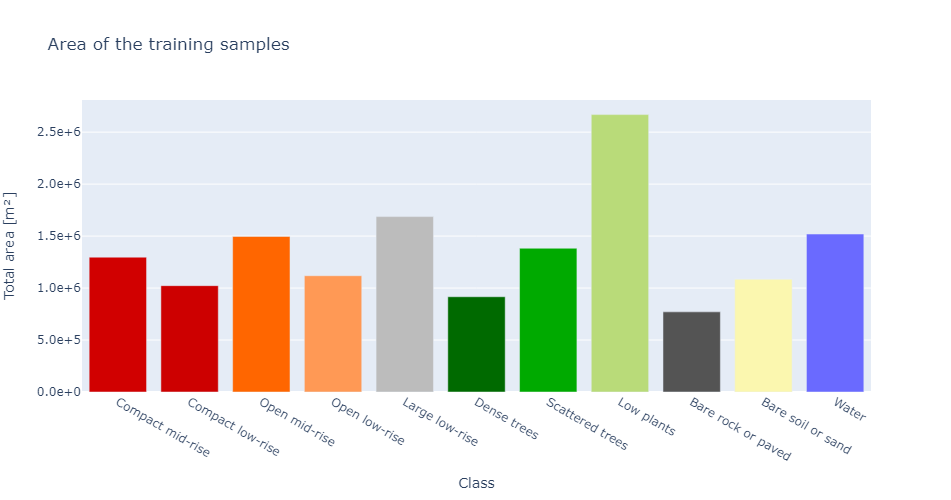

In [163]:
vector_LCZ_path = training_area(sel_prisma_date, legend)

## 2. <a id='sec2'></a>Rasterize training samples
[Back to top](#TOC_TOP)

In order to perform the classification, it is necessary to convert the training set (provided in vector format as Geopackage) in raster format using the following functions.

You need to set the following variables: (1) `raster_reference`, image to be classified (GeoTIFF) that will be used as reference image; metadata (including the spatial resolution) of the rasterized training set is obtained from the reference image; (2) `attribute`: field to be used for creating the raster; in this case, the `LCZ` field number of the vector file is used to set the value of each pixel in the rasterized training set; (3) `output`: output location and name of the complete rasterized training set (GeoTIFF); (4) `projection`: projection of the rasterized image; in this case, `EPSG:32632` is used.

In [164]:
raster_reference = 'PCs/PCs_'+ sel_prisma_date.replace('-', '') +'_30m.tif'
output = './layers/training_samples/training_set_'+ sel_prisma_date.replace('-', '') + '_30m.tif'
attribute = 'LCZ'
projection = 32632

The following function is meant to rasterize the training sample file. <br>
In this case we used the image of 9th February 2023 as reference image for rasterization, since it covers the whole study area. This is done in order to get the complete rasterized training samples over the whole area (without clipped parts that may be generated using images that are not exacly located over the study area).<br>
However, in principle, it is possible to pass to the function the specified `raster_reference`.

In [165]:
rasterized_result = rasterize_training('PCs/PCs_20230209_30m.tif', vector_LCZ_path, output, attribute, projection)

The file has been rasterized!


Optionally, you can use the following function to plot the rasterized training samples.

In [166]:
#plot_raster_training(output, legend)

## 3. <a id='sec3'></a>Import useful layers and prepare data for training
[Back to top](#TOC_TOP)

Before performing the classification, it is necessary to import the useful layers and to prepare them for training.

First, the bounding box for clipping the images to the correct extent must be obtained. The following function generates a Geopackage file with the extent of the selected PRISMA image footprint. The Geopackage is saved in the `study_area` folder which is automatically created if not yet existing.

In [167]:
bbox = prisma_bbox(selected_prisma_image, sel_prisma_date)

BoundingBox(left=489680.0, bottom=5015540.0, right=525770.0, top=5050460.0)
The bounding box has been generated and saved in study_area/study_area_20230808.gpkg.


Then, it is necessary to create a mask defining the extent of the area where PRISMA data is available.<br>
The mask will be applied to all the layers used in the classification.

</div>
<div class="alert alert-warning" role="alert">
<span>&#9888;</span>
<a id='warning'></a>

**Note**:
The mask contains `1` where PRISMA data is available and `0` at the edges, since `nan` is not supported by the `scikit-learn` library for classification purposes.
</div>

PRISMA mask shape --> (1164, 1203)


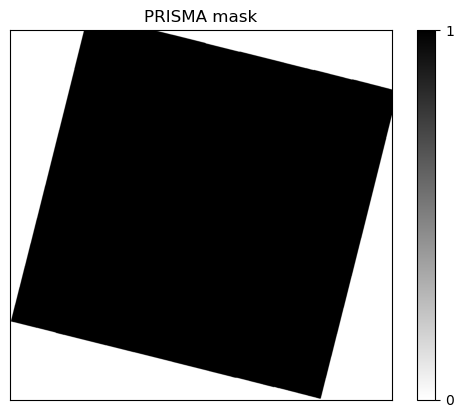

In [168]:
mask_prisma = mask_prisma_image(selected_prisma_image)

At this point, the user must import the layers that will be used for the classification. In this case, the following layers (GeoTIFF) are imported:
* Urban Canopy Layers (*UCL*) including:
    - *imperviousness layer* retrieved from [Copernicus Imperviousness Density 2018](https://land.copernicus.eu/pan-european/high-resolution-layers/imperviousness/status-maps/imperviousness-density-2018);
    - *building heights* retrieved from [Geo-Topographic Database (DBGT) of Regione Lombardia](https://www.regione.lombardia.it/wps/portal/istituzionale/HP/DettaglioServizio/servizi-e-informazioni/Enti-e-Operatori/Territorio/sistema-informativo-territoriale-sit/database-topografico-regionale/database-topografico-regionale);
    - *sky view factor* computed from DBGT using the homonymous built-in function of [SAGA-GIS](https://saga-gis.sourceforge.io/en/index.html);
    - *building percentage* for each pixel, calculated from DBGT;
    - *tree canopy height* retrieved from [ETH Global Sentinel-2 10m Canopy Height (2020)](https://gee-community-catalog.org/projects/canopy/);
* PRISMA image Principal Components (*PCs*).

The rasterized *training samples*, which will be used to train the classifier, have already been computed and imported in the previous section.

Import the UCL:

In [169]:
imperv_new_path = 'layers/ucp/imperviousness_' + sel_prisma_date.replace('-', '') + '_30m.tif'
perc_build_new_path = 'layers/ucp/percentage_buildings_' + sel_prisma_date.replace('-', '') + '_30m.tif'
svf_new_path = 'layers/ucp/SVF_' + sel_prisma_date.replace('-', '') + '_30m.tif'
canopy_height_new_path = 'layers/ucp/canopy_height_ETH_' + sel_prisma_date.replace('-', '') + '_30m.tif'
buildings_new_path = 'layers/ucp/buildings_' + sel_prisma_date.replace('-', '') + '_30m.tif'

The following function clips the UCL to the extent of the PRISMA image:

In [170]:
# Load the GeoPackage vector file representing the bounding box
study_area = gpd.read_file(bbox)

In [171]:
clip_image_study_area('layers/ucp/imperviousness_30m.tif', imperv_new_path, study_area)
clip_image_study_area('layers/ucp/percentage_buildings_30m.tif', perc_build_new_path, study_area)
clip_image_study_area('layers/ucp/SVF_30m.tif', svf_new_path, study_area)
clip_image_study_area('layers/ucp/canopy_height_ETH_30m.tif', canopy_height_new_path, study_area)
clip_image_study_area('layers/ucp/buildings_30m.tif', buildings_new_path, study_area)

layers/ucp/imperviousness_20230808_30m.tif created!
layers/ucp/percentage_buildings_20230808_30m.tif created!
layers/ucp/SVF_20230808_30m.tif created!
layers/ucp/canopy_height_ETH_20230808_30m.tif created!
layers/ucp/buildings_20230808_30m.tif created!


With the following function, the UCL are rescaled so that their values are between 0 and 1, and the PRISMA image mask is applied to each of them in order to have area matching.

In [172]:
imperv = open_layer(imperv_new_path, mask_prisma)
perc_build = open_layer(perc_build_new_path, mask_prisma)
svf = open_layer(svf_new_path, mask_prisma)
canopy_height = open_layer(canopy_height_new_path, mask_prisma)
buildings = open_layer(buildings_new_path, mask_prisma)

layers/ucp/imperviousness_20230808_30m.tif shape: (1164, 1203) ---> Max value: 1.00 | Min value: 0.00
layers/ucp/percentage_buildings_20230808_30m.tif shape: (1164, 1203) ---> Max value: 1.00 | Min value: 0.00
layers/ucp/SVF_20230808_30m.tif shape: (1164, 1203) ---> Max value: 1.00 | Min value: 0.30
layers/ucp/canopy_height_ETH_20230808_30m.tif shape: (1164, 1203) ---> Max value: 1.00 | Min value: 0.00
layers/ucp/buildings_20230808_30m.tif shape: (1164, 1203) ---> Max value: 1.00 | Min value: 0.00


The following function displays the UCL:

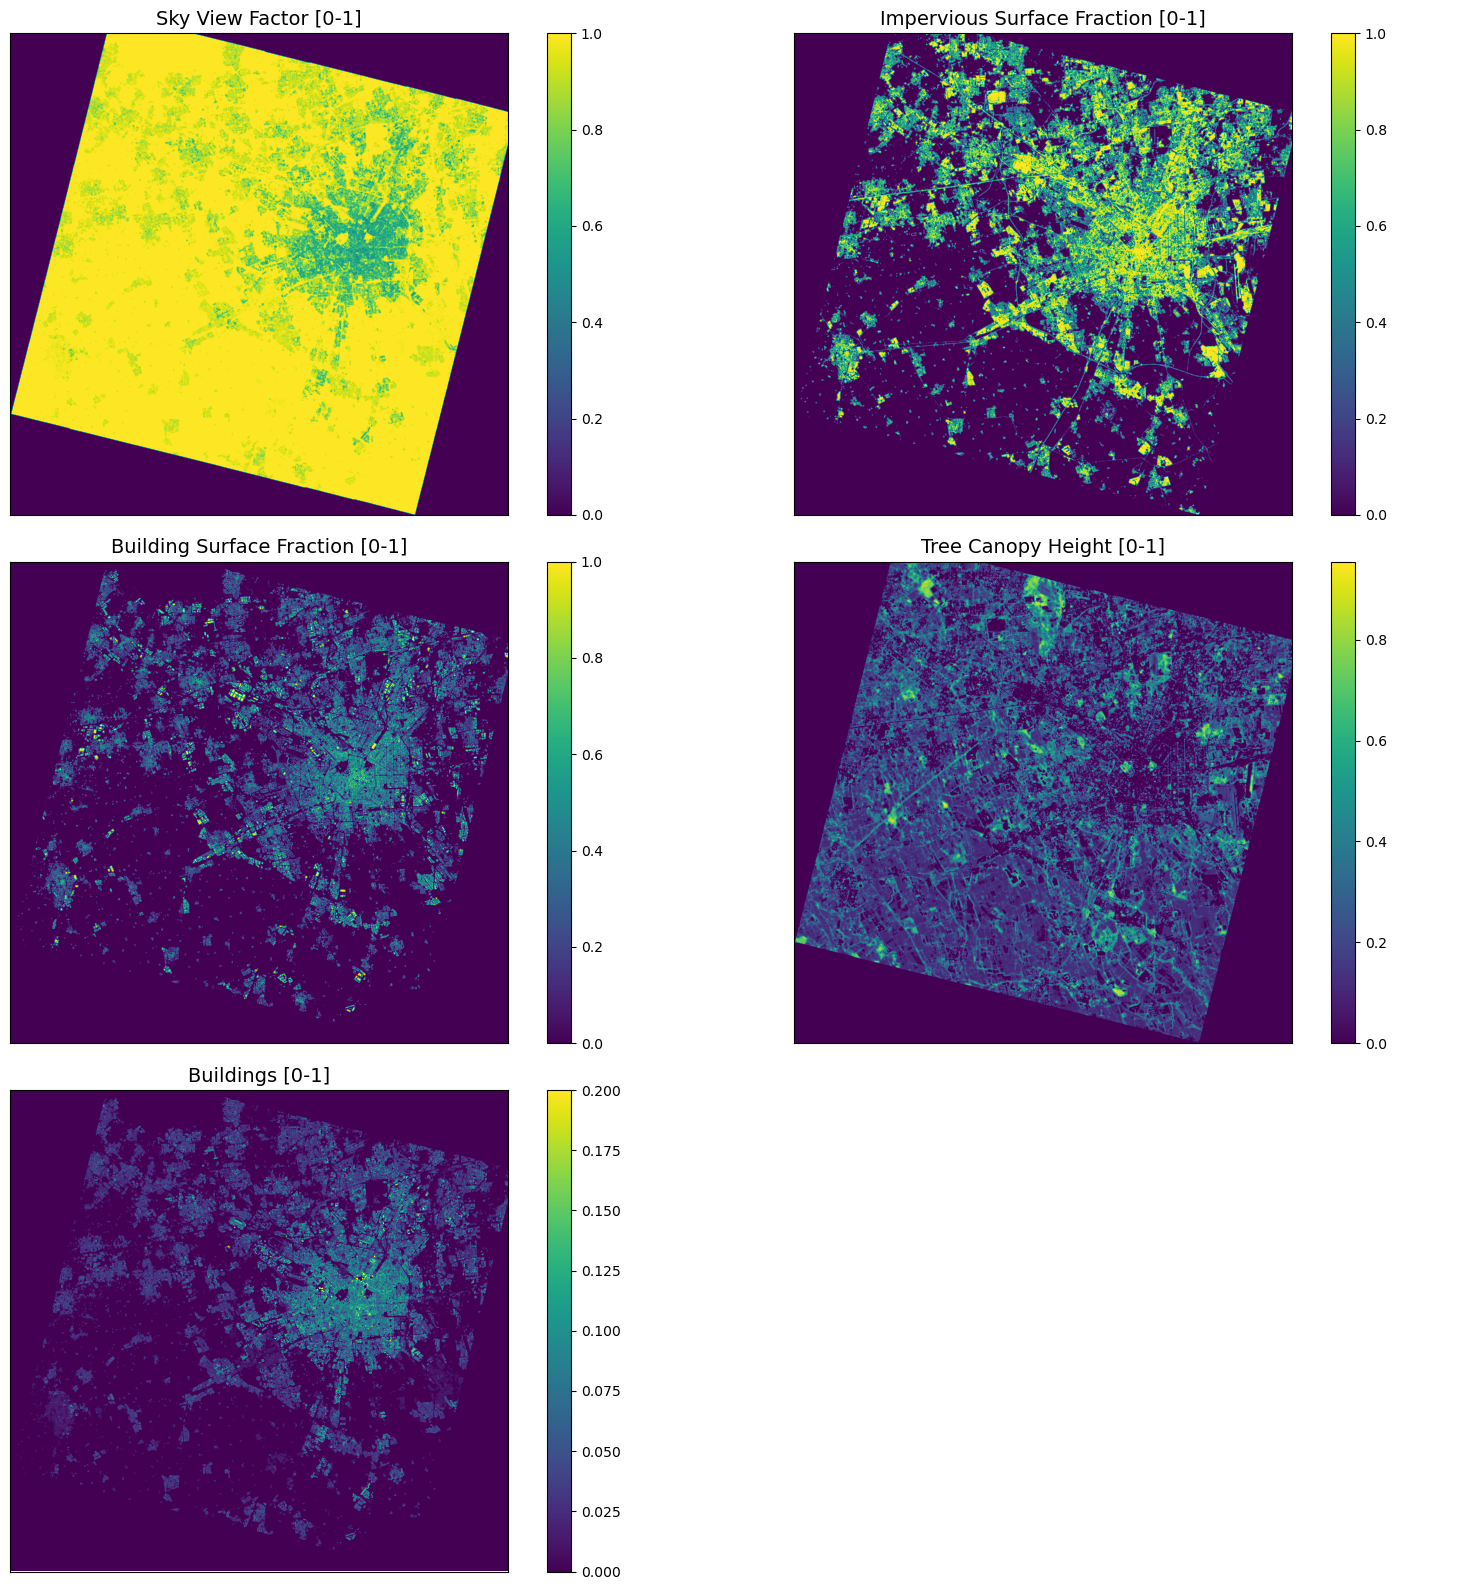

In [173]:
plot_ucl(imperv, perc_build, svf, canopy_height, buildings)

Make also sure that the training sample is clipped to the correct extent with the following function:

In [174]:
img, roi = clip_training_sample(raster_reference, output, sel_prisma_date, study_area)

./layers/training_samples/training_set_20230808_30m.tif created!
Classes in the ROI:  [  0   2   3   5   6   8 101 102 104 105 106 107]


Check the dimension of the layers used for the classification and expand if necessary. This is done to match layers dimensions:

In [175]:
imperv, perc_build, svf, canopy_height, buildings, roi = check_layers_dimension(imperv, perc_build, svf, canopy_height, buildings, roi, img)

Impervious shape:  (1164, 1203, 1)
Build percentage shape:  (1164, 1203, 1)
SVF shape:  (1164, 1203, 1)
Tree Canopy Height shape:  (1164, 1203, 1)
Building shape:  (1164, 1203, 1)
ROI shape:  (1164, 1202)
PRISMA PC image:  (1164, 1203, 10)
(1164, 1202)
0 1
The ROI shape is --> (1164, 1203)


Stack all the layers (PRISMA PCs and the previously shown layers):

In [176]:
img = np.dstack((imperv, perc_build, svf, canopy_height, buildings, img))
print(f"The stacked array shape is --> {img.shape}")

The stacked array shape is --> (1164, 1203, 15)


Set the classification labels, and the training samples:

In [177]:
labels = np.unique(roi[roi > 0])
print(f'The training data include {labels.size} classes: {labels}')

The training data include 11 classes: [  2   3   5   6   8 101 102 104 105 106 107]


In [178]:
X = img[roi > 0, :] 
y = roi[roi > 0]
print(f'X matrix size: {X.shape}')
print(f'y array size: {y.shape}')

X matrix size: (16624, 15)
y array size: (16624,)


## 4. <a id='sec4'></a>Classifier training
[Back to top](#TOC_TOP)

This section performs the classification. First, training samples are split into training and testing sets. <br>
Then, the user can select the classification method. Available methods are **Random Forest** (RF), XGBoost (XGB), AdaBoosting (AD) and GradientBoosting (BG). <br>
Hyperparameters tuning is performed so that the combination of parameters yielding the best accuracy on the testing set is exploited.

A remark about the classification methods:<br>
RF: The Random Forest classifier is created using `RandomForestClassifier()`. It uses an ensemble of decision trees for classification. The classifier is configured with different hyperparameters, such as the number of estimators and maximum features, which are specified in the `param_grid` dictionary. The algorithm aims to find the best combination of hyperparameters using `GridSearchCV`.<br>
XGB: The XGBoost classifier is created using `xgb.XGBClassifier()`. XGBoost is an optimized gradient boosting library that provides fast and accurate implementations of gradient boosting algorithms. Similar to the previous classifiers, hyperparameters such as the number of estimators and learning rate are tuned using `GridSearchCV`.<br>
AB: The AdaBoost classifier is created using `AdaBoostClassifier()`. It combines multiple weak classifiers to create a strong classifier. Similar to Random Forest, the classifier is tuned using `GridSearchC` to optimize the number of estimators and learning rate.<br>
GB: The Gradient Boosting classifier is created using `GradientBoostingClassifier()`. It builds an ensemble of decision trees in a sequential manner. The classifier is tuned using `GridSearchCV` to optimize hyperparameters such as learning rate, maximum features, criterion, and number of estimators.

First, it's needed to split train and test data (80% for training and 20% for testing):

In [179]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Select the classification method:

In [180]:
classification_method_w = widgets.RadioButtons(
    options=['RandomForest', 'XGBoost', 'AdaBoost', 'GradientBoost'],
    value='RandomForest', # Defaults to 'pineapple'
    layout={'width': 'max-content'}, # If the items' names are long
    description='Classifier:',
    disabled=False
)
classification_method_w

RadioButtons(description='Classifier:', layout=Layout(width='max-content'), options=('RandomForest', 'XGBoost'…

In [181]:
classification_method = classification_method_w.value
print(f'Selected classification method: {classification_method}')

Selected classification method: RandomForest


The following function performs hyperparameter tuning for the selected classification algorithm, and returns the best hyperparameter. The selection is done by computing the accuracy score:

$ {Accuracy Score} = {(TP+TN)\over(TP+FN+TN+FP)}$

where $TP$ and $TN$ are true positives/negatives, $FP$ abd $FN$ are false positives/negatives.

In [182]:
best_params = parameter_tuning(classification_method, X_train, y_train)

Using Random Forest
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START criterion=gini, max_features=auto, n_estimators=100.........
[CV 1/5; 1/4] END criterion=gini, max_features=auto, n_estimators=100;, score=0.950 total time=   3.3s
[CV 2/5; 1/4] START criterion=gini, max_features=auto, n_estimators=100.........
[CV 2/5; 1/4] END criterion=gini, max_features=auto, n_estimators=100;, score=0.945 total time=   3.2s
[CV 3/5; 1/4] START criterion=gini, max_features=auto, n_estimators=100.........
[CV 3/5; 1/4] END criterion=gini, max_features=auto, n_estimators=100;, score=0.954 total time=   3.5s
[CV 4/5; 1/4] START criterion=gini, max_features=auto, n_estimators=100.........
[CV 4/5; 1/4] END criterion=gini, max_features=auto, n_estimators=100;, score=0.951 total time=   3.4s
[CV 5/5; 1/4] START criterion=gini, max_features=auto, n_estimators=100.........
[CV 5/5; 1/4] END criterion=gini, max_features=auto, n_estimators=100;, score=0.942 total time=   3.3s


The following function creates classifier objects based on the selected classification method. The classifier is created with the hyperparameters yielding the best performance based on the accuracy score.

In [183]:
y_pred, clc = classification(classification_method, best_params, X_train, y_train, X_test)

## 5. <a id='sec5'></a> Accuracy assessment
[Back to top](#TOC_TOP)

Calculate accuracy, confusion matrix and statistics:

In [184]:
# Calculate the accuracy of the best model on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.943


https://github.com/jrkreiger/random-forest-trees/blob/master/random-forest-for-trees.ipynb

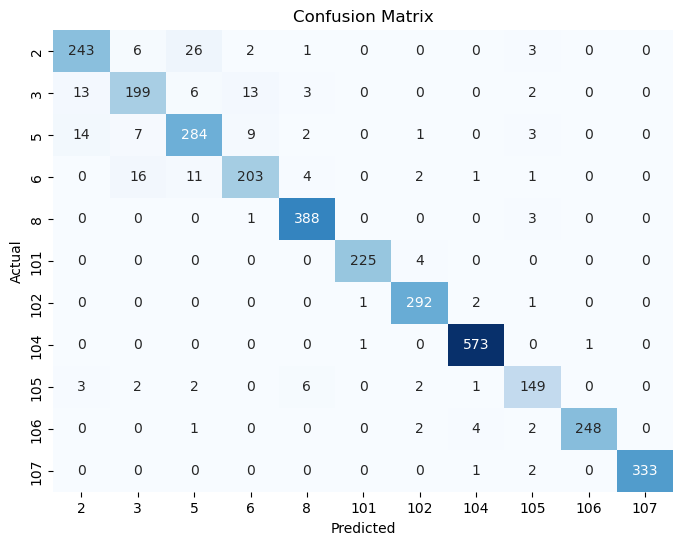

-------
Accuracy: 0.94
-------
Classification Report:
              precision    recall  f1-score   support

           2       0.89      0.86      0.88       281
           3       0.87      0.84      0.85       236
           5       0.86      0.89      0.87       320
           6       0.89      0.85      0.87       238
           8       0.96      0.99      0.97       392
         101       0.99      0.98      0.99       229
         102       0.96      0.99      0.97       296
         104       0.98      1.00      0.99       575
         105       0.90      0.90      0.90       165
         106       1.00      0.96      0.98       257
         107       1.00      0.99      1.00       336

    accuracy                           0.94      3325
   macro avg       0.94      0.93      0.93      3325
weighted avg       0.94      0.94      0.94      3325



In [185]:
print_metrics(y_test, y_pred)

## 6. <a id='sec6'></a> Classified image filtering and export
[Back to top](#TOC_TOP)

The classified map is exported with the following function. The path is directly set within the function depending on the name of the original PRISMA image.<br>
The function also applies a post-processing to the classified image using the [scipy median filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.median_filter.html). This is done to remove isolated pixels obtained from the classification.

In [186]:
export_classified_map(img, clc, X, mask_prisma, selected_prisma_image, classification_method, sel_prisma_date)

Using RandomForest
Reshaped from (1164, 1203, 15) to (1400292, 15)
Folder already exists.
The classified file /classified_RandomForest_20230808_30m.tif has been created!
Application of a median filter of size 3...
The smoothed classified file /classified_RandomForest_20230808_medianfilter_30m.tif has been created!


## 7. <a id='sec7'></a>Plot classified image
[Back to top](#TOC_TOP)

In [ ]:
#def plot_classified_image(classification_method, sel_prisma_date):
    
#    # Open the image file using rasterio
#    folder_path = 'classified_images'
#    with rasterio.open(folder_path + '/classified_' + classification_method + '_' + sel_prisma_date.replace('-', '') + '_medianfilter_30m.tif') as dataset:
#        # Read the image data
#        image_data = dataset.read()
    
#    # Plot the raster data with a custom figure size
#    fig = plt.figure(figsize=(14, 14))
#    ax = fig.add_subplot(1, 1, 1)
#    plt.title(f"Classified LCZ image with {classification_method}")
#    show(image_data, cmap=cmap, ax=ax, interpolation='none',norm=norm);

#    cmap = colors.ListedColormap([colors_dict[key] for key in colors_dict])

#    # Add a legend with the correct class colors
#    labels = list(colors_dict.keys())
#    handles = [plt.Rectangle((0, 0), 1, 1, color=colors_dict[label]) for label in labels]
#    legend = plt.legend(handles, labels, title='LCZ Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
#    plt.setp(legend.get_title(), fontsize='12')  # Adjust the font size of the legend title

#    # Adjust the plot layout to accommodate the legend outside
#    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Increase the left margin to make space for the legend

#    plt.show()